In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from tensorflow import random_normal_initializer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Flatten, BatchNormalization, Dropout, Reshape, Activation
import tensorflow.keras as keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import LSTM, Dense, Conv1D, Flatten, Dropout, Masking, Embedding, SimpleRNN
from collections import Counter
from datetime import datetime

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ParameterGrid, RandomizedSearchCV
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

In [ ]:
from mlxtend.regressor import StackingCVRegressor

from catboost import CatBoostRegressor
from itertools import product, chain
from tqdm import tqdm
import math

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
import time
import shap
import re

import os
import tensorflow as tf
import random
def reset_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(9125)
    tf.random.set_seed(9125)
    np.random.seed(9125)
    random.seed(9125)

/common/home/projectgrps/IS460/IS460G4/.local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer

import spacy
sp = spacy.load('en_core_web_sm')
#nlp = spacy.load("en_ner_bc5cdr_md")
from collections import Counter

# 1. Exploratory Data Analysis (EDA)

In [ ]:
# Load data
df = pd.read_csv("Data/train.csv")
df.head()

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost
0,WC8285054,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,48,M,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.203388
1,WC6982224,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,43,F,M,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6326.285819
2,WC5481426,1996-03-25T00:00:00Z,1996-04-14T00:00:00Z,30,M,U,0,0,709.10,F,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1700,2293.949087
3,WC9775968,2005-06-22T13:00:00Z,2005-07-22T00:00:00Z,41,M,S,0,0,555.46,F,38.0,5,DIGGING LOWER BACK LOWER BACK STRAIN,15000,17786.487170
4,WC2634037,1990-08-29T08:00:00Z,1990-09-27T00:00:00Z,36,M,M,0,0,377.10,F,38.0,5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,2800,4014.002925


In [ ]:
#Check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ClaimNumber                54000 non-null  object 
 1   DateTimeOfAccident         54000 non-null  object 
 2   DateReported               54000 non-null  object 
 3   Age                        54000 non-null  int64  
 4   Gender                     54000 non-null  object 
 5   MaritalStatus              53971 non-null  object 
 6   DependentChildren          54000 non-null  int64  
 7   DependentsOther            54000 non-null  int64  
 8   WeeklyWages                54000 non-null  float64
 9   PartTimeFullTime           54000 non-null  object 
 10  HoursWorkedPerWeek         54000 non-null  float64
 11  DaysWorkedPerWeek          54000 non-null  int64  
 12  ClaimDescription           54000 non-null  object 
 13  InitialIncurredCalimsCost  54000 non-null  int

In [ ]:
# Check duplicate rows in the dataset
df.duplicated().sum()

0

In [ ]:
# Check key statistics --> outlier in ultimate claim cost
df.describe().round(1)

,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,InitialIncurredCalimsCost,UltimateIncurredClaimCost
count,54000.0,54000.0,54000.0,54000.0,54000.0,54000.0,54000.0,54000.0
mean,33.8,0.1,0.0,416.4,37.7,4.9,7841.1,11003.4
std,12.1,0.5,0.1,248.6,12.6,0.6,20584.1,33391.0
min,13.0,0.0,0.0,1.0,0.0,1.0,1.0,121.9
25%,23.0,0.0,0.0,200.0,38.0,5.0,700.0,926.3
50%,32.0,0.0,0.0,392.2,38.0,5.0,2000.0,3371.2
75%,43.0,0.0,0.0,500.0,40.0,5.0,9500.0,8197.2
max,81.0,9.0,5.0,7497.0,640.0,7.0,2000000.0,4027135.9


In [ ]:
# Check missing values --> missing values in Marital Status
df.isnull().sum()

ClaimNumber                   0
DateTimeOfAccident            0
DateReported                  0
Age                           0
Gender                        0
MaritalStatus                29
DependentChildren             0
DependentsOther               0
WeeklyWages                   0
PartTimeFullTime              0
HoursWorkedPerWeek            0
DaysWorkedPerWeek             0
ClaimDescription              0
InitialIncurredCalimsCost     0
UltimateIncurredClaimCost     0
dtype: int64

[Text(0, 0, '41660'), Text(0, 0, '12338'), Text(0, 0, '2')]

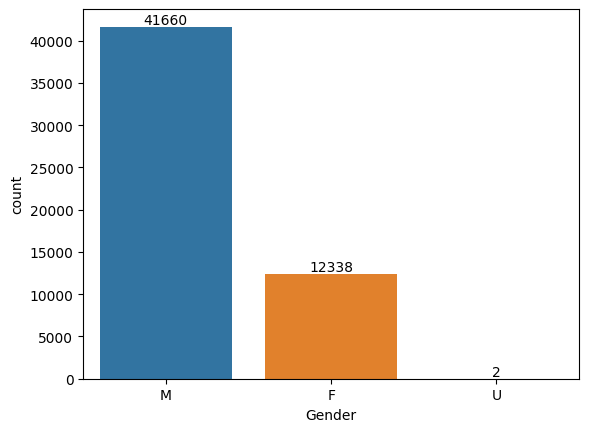

In [ ]:
# Check distribution of Gender
ax = sns.countplot(data = df, x = "Gender")
ax.bar_label(ax.containers[0])

[Text(0, 0, '49112'), Text(0, 0, '4888')]

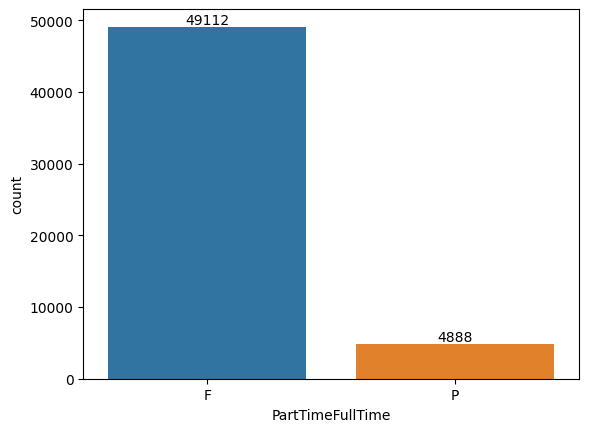

In [ ]:
# Check distribution of Parttime/Fulltime status
ax = sns.countplot(data = df, x = "PartTimeFullTime")
ax.bar_label(ax.containers[0])

<AxesSubplot:xlabel='DependentsOther', ylabel='Count'>

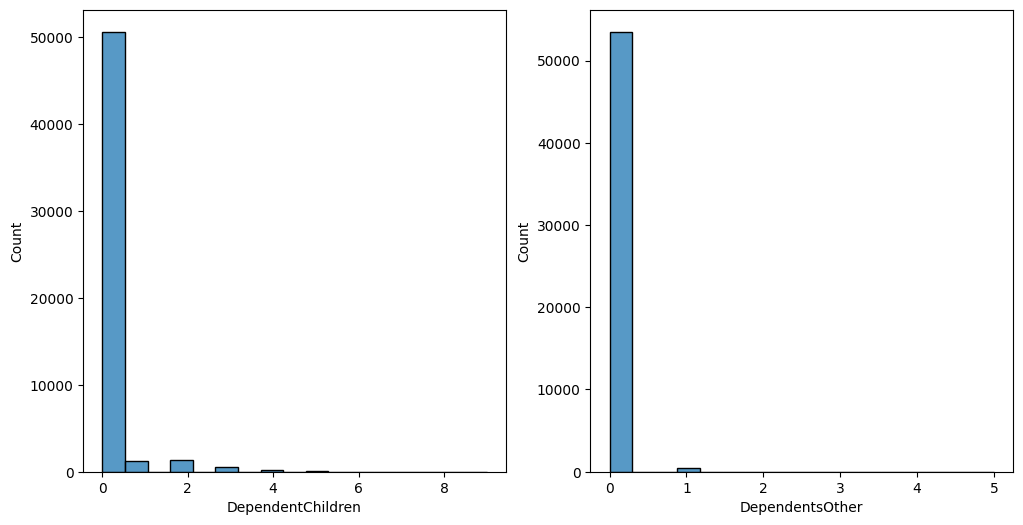

In [ ]:
# Check distribution of Dependent Children & Dependent Other
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,6))
sns.histplot(ax = axes[0], data = df, x = "DependentChildren", kde = False)
sns.histplot(ax = axes[1], data = df, x = "DependentsOther", kde = False)

<AxesSubplot:xlabel='DaysWorkedPerWeek', ylabel='Count'>

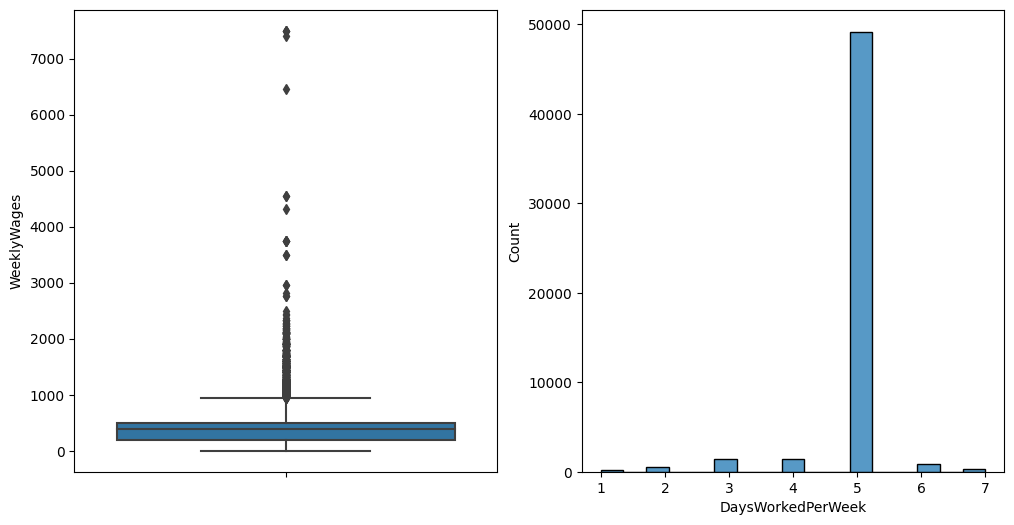

In [ ]:
# Check distribution of wages and Days worked per week
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,6))
sns.boxplot(ax = axes[0], data = df, y = "WeeklyWages")
sns.histplot(ax = axes[1], data = df, x = "DaysWorkedPerWeek", kde = False)


<AxesSubplot:ylabel='UltimateIncurredClaimCost'>

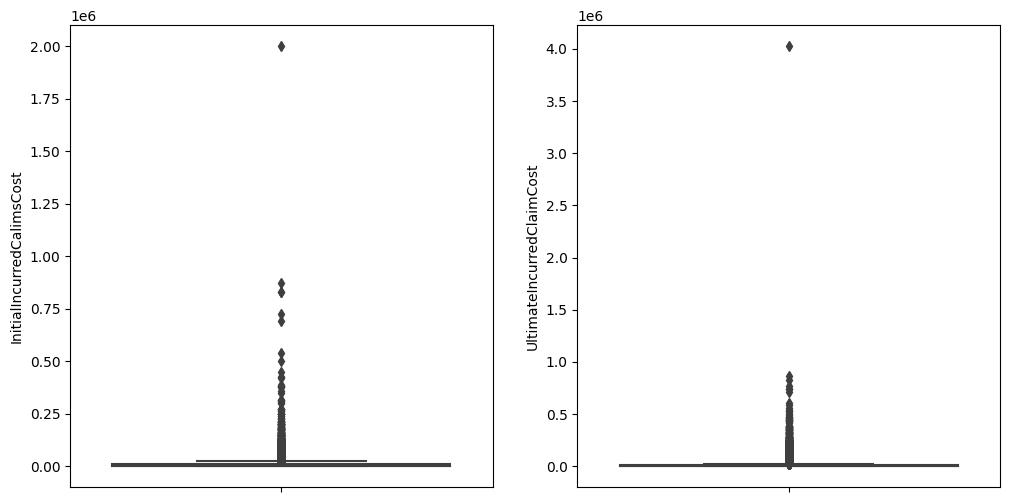

In [ ]:
# Check distribution of Initial claim cost and Ultimate claim cost
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,6))
sns.boxplot(ax = axes[0], data = df, y = "InitialIncurredCalimsCost")
sns.boxplot(ax = axes[1], data = df, y = "UltimateIncurredClaimCost")

<AxesSubplot:>

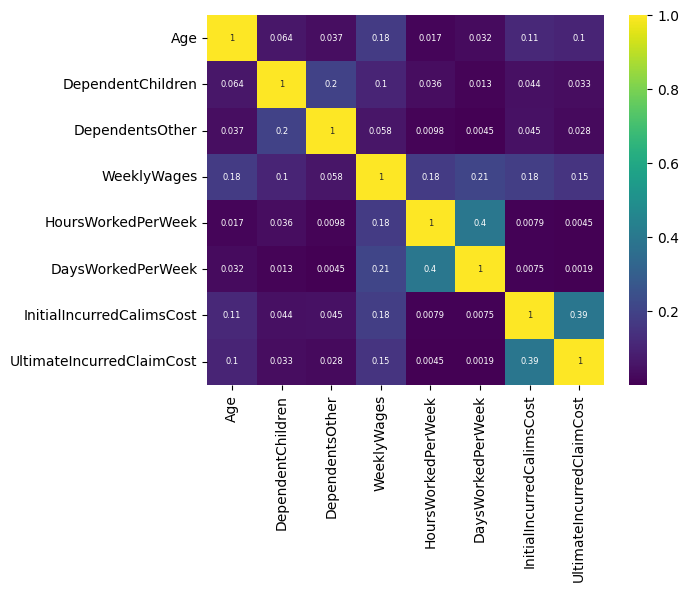

In [ ]:
# Check for positive correlation in the dataset
plt.plot(figsize = (16,9))
sns.heatmap(df.corr(), cmap = 'viridis',annot = True, annot_kws={"size":6})

# 2. Data Preprocessing

In [ ]:
# Extract columns name
df.columns

Index(['ClaimNumber', 'DateTimeOfAccident', 'DateReported', 'Age', 'Gender',
       'MaritalStatus', 'DependentChildren', 'DependentsOther', 'WeeklyWages',
       'PartTimeFullTime', 'HoursWorkedPerWeek', 'DaysWorkedPerWeek',
       'ClaimDescription', 'InitialIncurredCalimsCost',
       'UltimateIncurredClaimCost'],
      dtype='object')

#### Gender & Marital status
* Gender: replace missing values or unknown values "U" with "M" which is the dominant gender in the dataset
* Marital Status: replace missing value with "U" (Unknown)

In [ ]:
# Replace U with M under Gender column
df["Gender"] = np.where((df["Gender"].isna()) | (df["Gender"]=="U"), "M", df["Gender"])

# Replace missing values with U under MaritalStatus
df["MaritalStatus"] = df["MaritalStatus"].fillna('U')

#### Hours worked per week
* Cap HoursWorkedPerWeek at 100 which is equivalent to ~14 hours/day

In [ ]:
# Cap HoursWorkedPerWeek at 100 (~14 hours/day )
df['HoursWorkedPerWeek'] = np.where(df['HoursWorkedPerWeek'] >= 100, 100, df['HoursWorkedPerWeek'])

<AxesSubplot:xlabel='HoursWorkedPerWeek', ylabel='Count'>

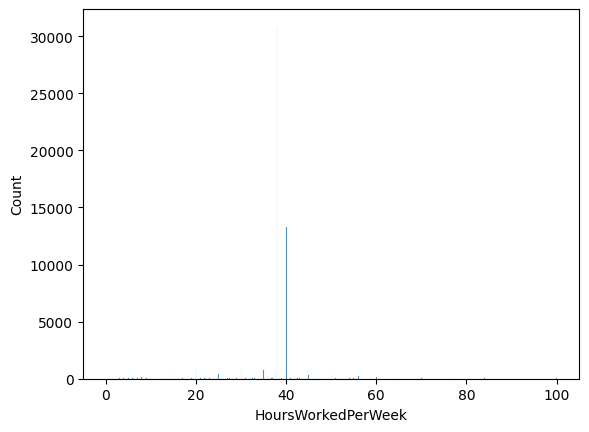

In [ ]:
sns.histplot(df["HoursWorkedPerWeek"], kde = False)

#### Claim number + Date of accident + Reporting delay in days
* Drop claim number as it is just an id indicator
* Extract Year/Quarter of Accident date
* Calculate the reporting delay in days --> clip data

In [ ]:
# Drop claim number as it is just an id indicator
df.drop('ClaimNumber',axis = 1, inplace = True)

# Extract from Date of Accident
df['YearOfAccident']  = pd.DatetimeIndex(df['DateTimeOfAccident']).year
df['QuarterOfAccident']  = pd.DatetimeIndex(df['DateTimeOfAccident']).quarter

# Reporting delay in days
df['DaysReportDelay'] = pd.DatetimeIndex(df['DateReported']).date - pd.DatetimeIndex(df['DateTimeOfAccident']).date
df['DaysReportDelay'] = (df['DaysReportDelay']  / np.timedelta64(1, 'D')).astype(int)

99th percentile of days delay is 296.0


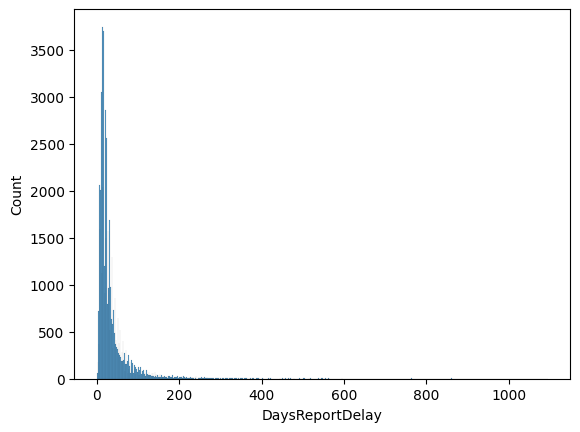

In [ ]:
# Check distribution of Reporting delay in days --> The distribution is right skewed
sns.histplot(df["DaysReportDelay"], kde = False)
print("99th percentile of days delay is", np.quantile(df["DaysReportDelay"], 0.99))

In [ ]:
# Clip Reporting delay in days at 300 days
df['DaysReportDelay'] = np.clip(df['DaysReportDelay'], a_max=300, a_min=None)

#### Severity indicator based in initial claim cost + Standardize intial claim cost by year
* If intitial claim cost > 95th percentile --> severe claim

In [ ]:
##### Add Severity Indicator as a binary
quant_95 = np.percentile(df['InitialIncurredCalimsCost'], 95)
df['Severity_Ind'] = np.where(df['InitialIncurredCalimsCost'] >= quant_95, 1, 0)

In [ ]:
## Standardize InitialClaimCost group by Year
standard_by_year = df.groupby('YearOfAccident')['InitialIncurredCalimsCost'].agg(["mean", "std"]).reset_index()
df = df.merge(standard_by_year, how='left', on='YearOfAccident')

df['InitialIncurred_std'] = (df['InitialIncurredCalimsCost']-df['mean'])/df['std']
df.drop(['mean', 'std'], axis=1, inplace=True)

#### Ultimate claim cost
* Clip data at 1,000,000
* Transform data with log transformation

In [ ]:
## Clip the outlier
df['UltimateIncurredClaimCost'] = np.where(df['UltimateIncurredClaimCost'] > 1000000, 1000000., df['UltimateIncurredClaimCost'])

## Log transformation: To avoid confusion (e.g. log or untransformed), we give the target a new name: loss
df['UltimateLoss'] = np.log1p(df["UltimateIncurredClaimCost"])

#### Encode categorical variables (except claim description)

In [ ]:
# One hot encoding all categorical variables
df_obj = df[['Gender','MaritalStatus','PartTimeFullTime']]
dummies_df = pd.get_dummies(df_obj, drop_first = True)
df = pd.concat([df.drop(['Gender','MaritalStatus','PartTimeFullTime'],axis = 1),dummies_df],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54000 entries, 0 to 53999
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DateTimeOfAccident         54000 non-null  object 
 1   DateReported               54000 non-null  object 
 2   Age                        54000 non-null  int64  
 3   DependentChildren          54000 non-null  int64  
 4   DependentsOther            54000 non-null  int64  
 5   WeeklyWages                54000 non-null  float64
 6   HoursWorkedPerWeek         54000 non-null  float64
 7   DaysWorkedPerWeek          54000 non-null  int64  
 8   ClaimDescription           54000 non-null  object 
 9   InitialIncurredCalimsCost  54000 non-null  int64  
 10  UltimateIncurredClaimCost  54000 non-null  float64
 11  YearOfAccident             54000 non-null  int64  
 12  QuarterOfAccident          54000 non-null  int64  
 13  DaysReportDelay            54000 non-null  int

#### Drop unused columns

In [ ]:
### Drop unused columns
df = df.drop(['DateTimeOfAccident','DateReported','InitialIncurredCalimsCost',
              'UltimateIncurredClaimCost'],axis = 1)

<AxesSubplot:>

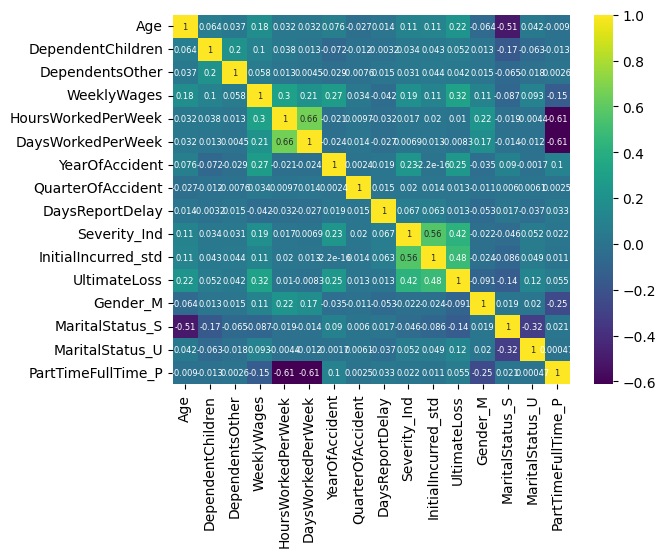

In [ ]:
# Double check again for positive correlation in the dataset
plt.plot(figsize = (16,9))
sns.heatmap(df.corr(), cmap = 'viridis',annot = True, annot_kws={"size":6})

# 3. Feature engineering on Claim description

#### Replace 'CARPAL' with 'CARPEL'

In [ ]:
# replace claimdescription rows with carpal to carpel

for i in range(len(df['ClaimDescription'])):
    if 'CARPAL' in df['ClaimDescription'][i]:
        df['ClaimDescription'][i] = df['ClaimDescription'][i].replace('CARPAL','CARPEL')


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Examine frequently appearing words in claim description

In [ ]:
# to tokenise transcription
tk =WhitespaceTokenizer()
def tokenise(df, attribute):
    df['tokenised'] = df.apply(lambda row: tk.tokenize(str(row[attribute])), axis=1)
    return df
df =tokenise(df, 'ClaimDescription')
df_experiment =df.copy()
df.head(3)

,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,YearOfAccident,QuarterOfAccident,DaysReportDelay,Severity_Ind,InitialIncurred_std,UltimateLoss,Gender_M,MaritalStatus_S,MaritalStatus_U,PartTimeFullTime_P,tokenised
0,48,0,0,500.00,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,2002,2,87,0,-0.437743,8.465732,1,0,0,0,"[LIFTING, TYRE, INJURY, TO, RIGHT, ARM, AND, W..."
1,43,0,0,509.34,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,1999,1,13,0,-0.147358,8.752627,0,0,0,0,"[STEPPED, AROUND, CRATES, AND, TRUCK, TRAY, FR..."
2,30,0,0,709.10,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1996,1,20,0,-0.271712,7.738466,1,0,1,0,"[CUT, ON, SHARP, EDGE, CUT, LEFT, THUMB]"


In [ ]:
# Stematizinf words
from nltk.stem.snowball import SnowballStemmer
def stemming(df, attribute):
    # Use English stemmer.
    stemmer = SnowballStemmer("english")
    df['stemmed'] = df[attribute].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.
    return df
df =stemming(df_experiment, 'tokenised')
df.head(2)

,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,YearOfAccident,QuarterOfAccident,DaysReportDelay,Severity_Ind,InitialIncurred_std,UltimateLoss,Gender_M,MaritalStatus_S,MaritalStatus_U,PartTimeFullTime_P,tokenised,stemmed
0,48,0,0,500.00,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,2002,2,87,0,-0.437743,8.465732,1,0,0,0,"[LIFTING, TYRE, INJURY, TO, RIGHT, ARM, AND, W...","[lift, tyre, injuri, to, right, arm, and, wris..."
1,43,0,0,509.34,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,1999,1,13,0,-0.147358,8.752627,0,0,0,0,"[STEPPED, AROUND, CRATES, AND, TRUCK, TRAY, FR...","[step, around, crate, and, truck, tray, fractu..."


In [ ]:
# Generate wordlist to see which words appears most frequently in the dataset
wordlist = {}
for i in df['stemmed']:
    for j in i:
        if j in wordlist.keys():
            wordlist[j] += 1
        else:
            wordlist[j] = 1
wordlist_df = pd.DataFrame({"word":wordlist.keys(),"counts":wordlist.values()})
wordlist_df.sort_values("counts",ascending=False).head(10)

,word,counts
4,right,22648
14,left,20756
24,strain,19433
23,back,16349
36,lacer,10237
22,lower,9954
6,and,9103
37,finger,9012
0,lift,8460
42,hand,7909


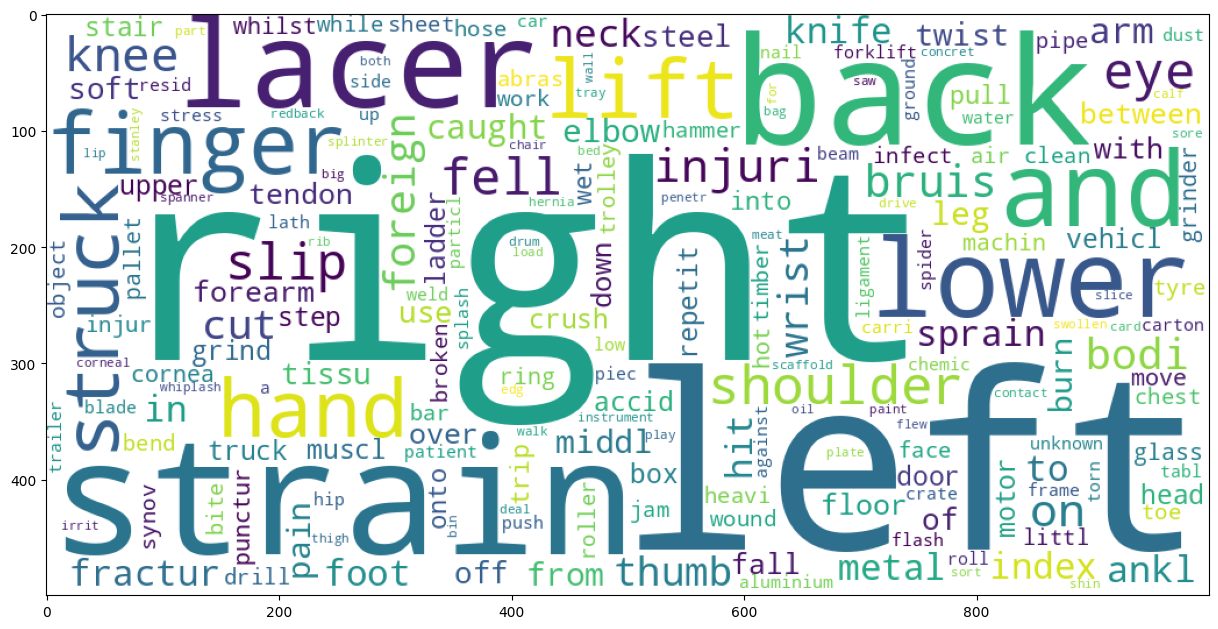

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white",width = 1000, height = 500).generate_from_frequencies(wordlist)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

#### Body Part

In [ ]:
from nltk.corpus import wordnet as wn
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
part = wn.synsets('body_part')[0]

def is_body_part(candidate):
    for ss in wn.synsets(candidate):
        # only get those where the synset matches exactly
        name = ss.name().split(".", 1)[0]
        if name != candidate:
            continue
        hit = part.lowest_common_hypernyms(ss)
        if hit and hit[0] == part:
            return True
    return False

[nltk_data] Downloading package wordnet to
[nltk_data]     /common/home/projectgrps/IS460/IS460G4/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /common/home/projectgrps/IS460/IS460G4/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
df['BodyParts'] = 'Unknown'
df['BodyParts_Minor'] = 'Unknown'
find_body_parts=[]
row=0
for j in df['stemmed']:
    for i in j:
        if is_body_part(i) and i !="left" and i!="right" and i!="side" and i!="index" and i!="back" and i!="front" and i not in find_body_parts:
            find_body_parts.append(i)
      # print(find_body_parts)

    if len(find_body_parts) == 1:
        df['BodyParts'].iloc[row] = find_body_parts[0]
    elif len(find_body_parts) >= 2:
        df['BodyParts'].iloc[row] = find_body_parts[0]
        df['BodyParts_Minor'].iloc[row] = find_body_parts[1]
    find_body_parts=[]
    row += 1

print("COMPLETE EXTRACTING BODY PART")


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


COMPLETE EXTRACTING BODY PART


#### Cause of injury

In [ ]:
##### Cause of Injury (verbs)
nltk.download('averaged_perceptron_tagger')
df['CauseOfInjury'] = 'Unknown'
accident = ['STRUCK','HAMMER','LADDER','STAIR','FELT','TRUCK','MOTOR']
row = 0
for j in df['ClaimDescription']:

    #### find verbs
    words = j.lower().split()
    tags = nltk.pos_tag(words)
    all_verbs = [tag[0] for tag in tags if tag[1].startswith('VB')and tag[0]!="leave"and tag[0]!="right"]
    ###### if no verbs tagged by NLTK, try spacy
    if len(all_verbs) == 0:
        sen = sp(j.lower())
        spacy_tags = [(sen.text.split()[i], sen[i].pos_) for i in range(len(sen.text.split()))]
        spacy_tags = [tag[0] for tag in spacy_tags if tag[1].startswith('VERB')]
        if len(spacy_tags) >= 1:
            all_verbs = spacy_tags

    if len(all_verbs) >= 1:
        find_verbs = [WordNetLemmatizer().lemmatize(word,'v') for word in all_verbs]
        df['CauseOfInjury'].iloc[row] = find_verbs[0]
        row += 1

df['CauseOfInjury'] = np.where(df['CauseOfInjury']=='fell', 'fall', df['CauseOfInjury'])

encoding_cause_of_injury = [k for k,v in Counter(df['CauseOfInjury']).items() if v>=100]
df['CauseOfInjury'] = np.where(df['CauseOfInjury'].isin(encoding_cause_of_injury) & (df['CauseOfInjury'] != 'Unknown'), df['CauseOfInjury'], 'Others')

print("COMPLETE EXTRACTING CAUSE OF INJURY")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /common/home/projectgrps/IS460/IS460G4/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


COMPLETE EXTRACTING CAUSE OF INJURY


In [ ]:
df.head(3)

,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,YearOfAccident,QuarterOfAccident,DaysReportDelay,...,UltimateLoss,Gender_M,MaritalStatus_S,MaritalStatus_U,PartTimeFullTime_P,tokenised,stemmed,BodyParts,BodyParts_Minor,CauseOfInjury
0,48,0,0,500.00,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,2002,2,87,...,8.465732,1,0,0,0,"[LIFTING, TYRE, INJURY, TO, RIGHT, ARM, AND, W...","[lift, tyre, injuri, to, right, arm, and, wris...",arm,wrist,lift
1,43,0,0,509.34,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,1999,1,13,...,8.752627,0,0,0,0,"[STEPPED, AROUND, CRATES, AND, TRUCK, TRAY, FR...","[step, around, crate, and, truck, tray, fractu...",forearm,Unknown,step
2,30,0,0,709.10,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1996,1,20,...,7.738466,1,0,1,0,"[CUT, ON, SHARP, EDGE, CUT, LEFT, THUMB]","[cut, on, sharp, edg, cut, left, thumb]",thumb,Unknown,cut


#### Disease/illness

In [ ]:
illness_list = ["fracture", "pain","tendonitis","abrasions","bruising","cornea",
          "rash","scabies","hernia","spasm","conjunctivitis","whiplash","synovitis",
          "eyelid","concussion","sore","allergy","anxiety","anaphylaxis","dermatitis",
          "trauma","sciatica","headaches","shock","depression","spasms","ulcer",
          "contusion","gastroenteritis","cellulitis","haematoma","numbness",
          "effusion","clippings","traumatic","abscess","prolapsed","keratitis","ache",
          "fractures","poisoning","headache","trench","spider"]

In [ ]:
df['illness']="Unknown"

row = 0
for j in df['ClaimDescription']:

    find_illness = [i for i in illness_list if i.upper() in j.split()]
    if len(find_illness) >= 1:
        df['illness'].iloc[row] = find_illness[0]
    row +=1

print("COMPLETE EXTRACTING CAUSE OF ILLNESS")


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


COMPLETE EXTRACTING CAUSE OF ILLNESS


In [ ]:
df['illness'].value_counts()

Unknown            46821
pain                1670
fracture            1298
bruising             841
cornea               666
synovitis            479
tendonitis           471
hernia               248
whiplash             231
sore                 215
concussion           109
dermatitis           104
contusion             95
trauma                84
shock                 82
abrasions             76
conjunctivitis        74
anxiety               70
spider                65
rash                  41
eyelid                25
trench                24
cellulitis            20
haematoma             18
spasm                 17
depression            17
traumatic             17
ulcer                 17
sciatica              15
fractures             13
headache              13
headaches              9
abscess                7
prolapsed              7
numbness               6
spasms                 6
scabies                6
ache                   6
poisoning              4
allergy                4


#### Drop claim description

In [ ]:
df.drop(["tokenised","stemmed"], axis = 1, inplace = True)

In [ ]:
df.drop("ClaimDescription",axis = 1, inplace = True)

## 4. Preparing data for model fitting

#### Split data into train & test set

In [ ]:
X = df.drop(['UltimateLoss'], axis=1)
y = df['UltimateLoss']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=9125)
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

#### Leave-One-Out Encoding (LOO Encoding)
https://medium.com/@kaoningyu/dont-use-one-hot-encoding-anymore-25b5882e533f

In [ ]:
#pip install category_encoders

In [ ]:
import category_encoders as ce

loo_encoder = ce.LeaveOneOutEncoder(cols=['BodyParts','BodyParts_Minor','CauseOfInjury','illness'], sigma=0.05)
loo_encoder.fit(X_train, y_train)
X_train = loo_encoder.transform(X_train)
X_test = loo_encoder.transform(X_test)

In [ ]:
X_train.head(3)

,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,YearOfAccident,QuarterOfAccident,DaysReportDelay,Severity_Ind,InitialIncurred_std,Gender_M,MaritalStatus_S,MaritalStatus_U,PartTimeFullTime_P,BodyParts,BodyParts_Minor,CauseOfInjury,illness
0,30,0,0,469.7,38.0,5,1994,4,23,0,-0.578771,1,1,0,0,7.336083,8.148941,8.038994,8.023728
1,26,0,0,304.0,38.0,5,1990,2,30,0,0.381402,1,0,0,0,8.938507,8.148941,8.038994,8.023728
2,20,0,0,200.0,38.0,5,2000,2,36,0,-0.444715,1,1,0,0,6.412965,8.148941,8.038994,8.023728


#### Scaling features

In [ ]:
#### Scale the variables
center_vars = ['Age', 'WeeklyWages', 'HoursWorkedPerWeek', 'DaysWorkedPerWeek', 'DaysReportDelay', 'YearOfAccident', 'QuarterOfAccident']

for i in center_vars:
    m, sd = np.mean(X_train[i]), np.std(X_train[i])
    X_train[i] = (X_train[i]-m)/sd
    X_test[i] = (X_test[i]-m)/sd

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48600 entries, 0 to 48599
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  48600 non-null  float64
 1   DependentChildren    48600 non-null  int64  
 2   DependentsOther      48600 non-null  int64  
 3   WeeklyWages          48600 non-null  float64
 4   HoursWorkedPerWeek   48600 non-null  float64
 5   DaysWorkedPerWeek    48600 non-null  float64
 6   YearOfAccident       48600 non-null  float64
 7   QuarterOfAccident    48600 non-null  float64
 8   DaysReportDelay      48600 non-null  float64
 9   Severity_Ind         48600 non-null  int64  
 10  InitialIncurred_std  48600 non-null  float64
 11  Gender_M             48600 non-null  uint8  
 12  MaritalStatus_S      48600 non-null  uint8  
 13  MaritalStatus_U      48600 non-null  uint8  
 14  PartTimeFullTime_P   48600 non-null  uint8  
 15  BodyParts            48600 non-null 

# 5. Building and tuning models

## 5.1. Light GBM

#### Tuning Hyperparameters with Bayesian Optimization
* Bayesian optimization: https://www.vantage-ai.com/en/blog/bayesian-optimization-for-quicker-hyperparameter-tuning
* Hyperparameters of light GBM: https://neptune.ai/blog/lightgbm-parameters-guide

In [ ]:
#pip install hyperopt

In [ ]:
from hyperopt import hp
from hyperopt.pyll import scope

In [ ]:
# Define search space
param_hyperopt= {
    'feature_fraction': hp.uniform('feature_fraction', 0, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 100)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 10, 100, 5)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'subsample': hp.uniform('subsample', 0, 1)
}

In [ ]:
from hyperopt import fmin, tpe, Trials, STATUS_OK
import time

#Define objective function
def objective_function(params):
        model = LGBMRegressor(**params)
        score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5).mean()
        return {'loss': -score, 'status': STATUS_OK}

In [ ]:
SEED = 9125
num_eval = 75
trials = Trials()

#Find best param by minimizing objective function
best_param = fmin(objective_function, param_hyperopt, algo=tpe.suggest, max_evals=num_eval, trials=trials, rstate= np.random.default_rng(SEED))

[LightGBM] [Warning] feature_fraction is set=0.8634669882228351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8634669882228351
[LightGBM] [Warning] feature_fraction is set=0.8634669882228351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8634669882228351
[LightGBM] [Warning] feature_fraction is set=0.8634669882228351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8634669882228351
[LightGBM] [Warning] feature_fraction is set=0.8634669882228351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8634669882228351
[LightGBM] [Warning] feature_fraction is set=0.8634669882228351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8634669882228351
[LightGBM] [Warning] feature_fraction is set=0.44558599747913186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44558599747913186
[LightGBM] [Warning] feature_fraction is set=0.44558599747913186, colsampl

In [ ]:
# Print out best_param
best_param

{'feature_fraction': 0.6062051122863168,
 'learning_rate': 0.03144182896023792,
 'n_estimators': 800.0,
 'num_leaves': 35.0,
 'reg_lambda': 0.36980637084230444,
 'subsample': 0.6810107052920281}

##### The best set of hyperparameters generated by Bayesian optimization is:

| Hyperparameter | Optimal value |
| --- | --- |
| feature_fraction | 0.6 |
| learning_rate | 0.03 |
| n_estimators | 800 |
| num_leaves | 35 |
| reg_lambda |  0.37 |
| subsample | 0.7|


#### <span style="color:red"> Important note when fitting LightGBM model </span>
When fitting Light GBM, 10-fold cross validation was used. Hence, X_train will be further split into:
* X_train1: train set; 9 folds of data
* X_val: validation set; 1 fold of data

In [ ]:
## LGBMRegressor: n-fold CV
import time
tic = time.time()

import gc
_ = gc.collect()

SEED = 9125
FOLDS = 10

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

## best pars selected from Bayesian hyper=opt
best_pars_lgb = {'feature_fraction': 0.6,
             'learning_rate': 0.03,
             'n_estimators': 800,
             'num_leaves': 35,
             'reg_lambda': 0.37,
             'subsample': 0.7}

# Split folds
skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# CV
rmse_cv = list()

for train_idx, val_idx in skf.split(X_train, y_train):
    X_train1, y_train1 = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
    X_val, y_val = X_train.iloc[val_idx, :], y_train.iloc[val_idx]

    LGB = LGBMRegressor(**best_pars_lgb)

    LGB.fit(X_train1, y_train1,
           eval_set=[(X_val, y_val)])

    result = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(LGB.predict(X_test))*1.31))  ## factor in the LDF and TF for LGB model only with log trans
    rmse_cv.append(result)

print("LGB model run time (sec):" + "%6.0f" % (time.time() - tic))

##### Avg RMSE from CV
print("LGB Average CV RMSE %0.3f ± %0.3f" % (np.mean(rmse_cv), np.std(rmse_cv)))

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[1]	valid_0's l2: 2.2724
[2]	valid_0's l2: 2.16755
[3]	valid_0's l2: 2.13393
[4]	valid_0's l2: 2.03707
[5]	valid_0's l2: 1.98255
[6]	valid_0's l2: 1.92249
[7]	valid_0's l2: 1.87894
[8]	valid_0's l2: 1.84411
[9]	valid_0's l2: 1.79172
[10]	valid_0's l2: 1.7433
[11]	valid_0's l2: 1.70297
[12]	valid_0's l2: 1.6566
[13]	valid_0's l2: 1.58644
[14]	valid_0's l2: 1.52463
[15]	valid_0's l2: 1.50525
[16]	valid_0's l2: 1.48134
[17]	valid_0's l2: 1.42065
[18]	valid_0's l2: 1.36366
[19]	valid_0's l2: 1.31365
[20]	valid_0's l2: 1.26205
[21]	valid_0's l2: 1.21767
[22]	valid_0's l2: 1.17909
[23]	valid_0's l2: 1.13491
[24]	valid_0's l2: 1.12228
[25]	valid_0's l2: 1.10329
[26]	valid_0's l2: 1.06304
[27]	valid_0's l2: 1.02526
[28]	valid_0's l2: 1.00854
[29]	valid_0's l2: 0.997568
[30]	valid_0's l2: 0.987211
[31]	valid_0's l2: 0.972316
[32]	valid_0's l2: 0.938987
[33]	valid_0's l2: 0

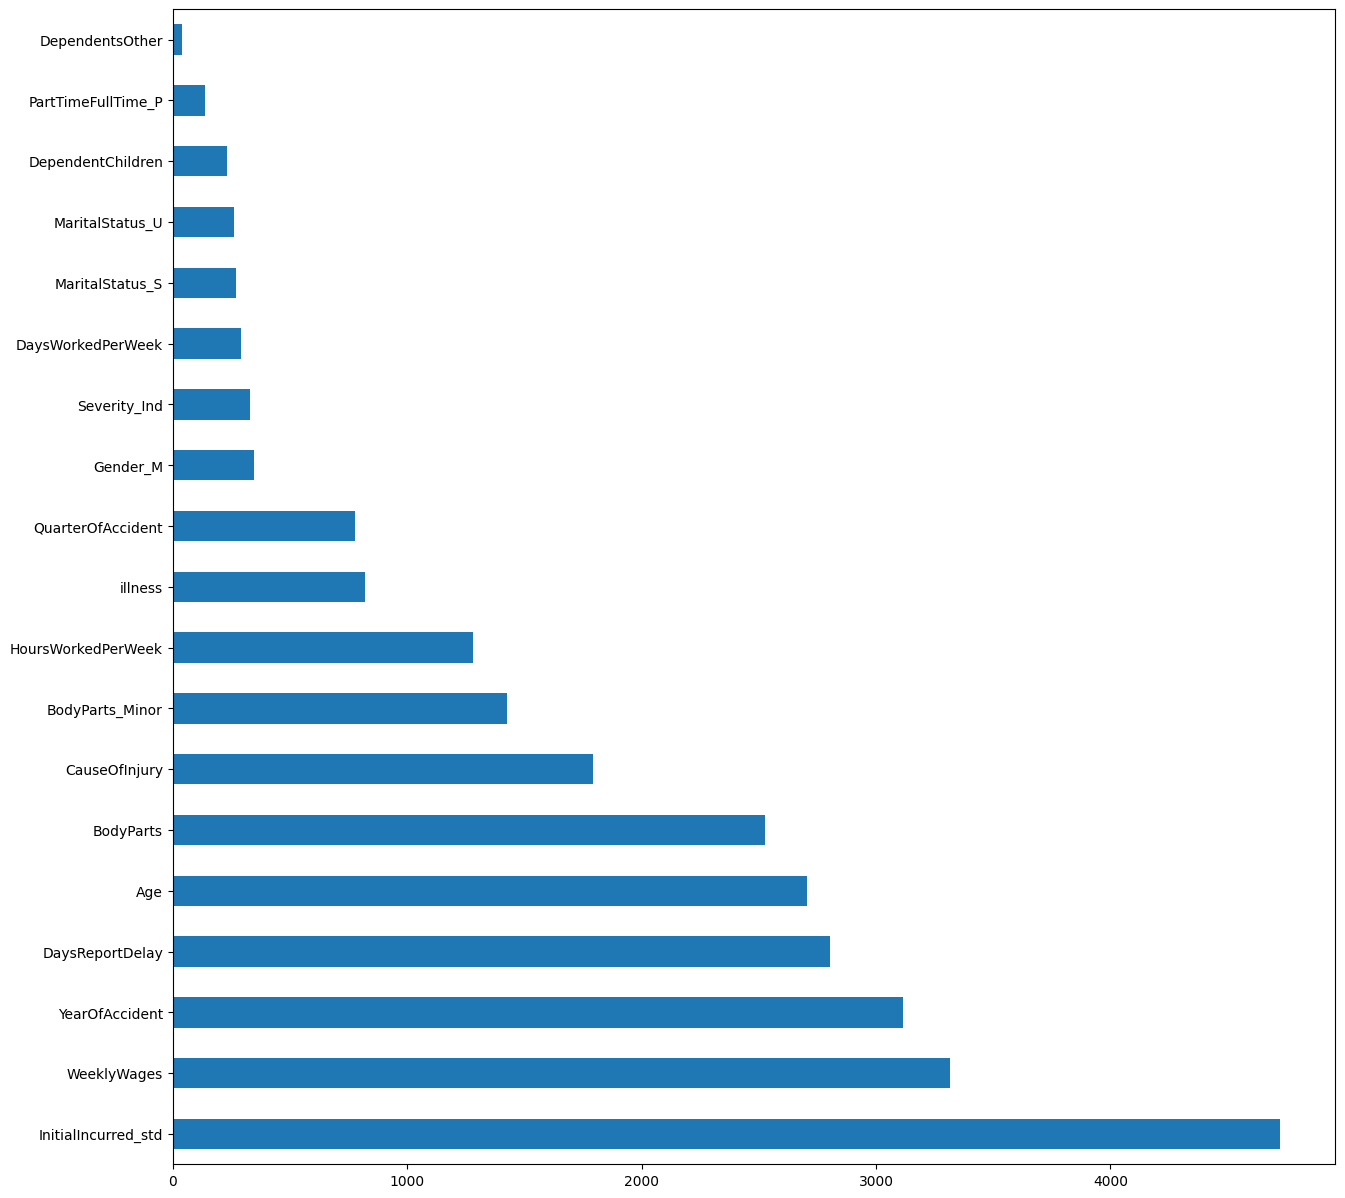

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 15, 15 ### 20, 20

(pd.Series(LGB.feature_importances_, index=X_train.columns).nlargest(30).plot(kind='barh'))
plt.show()

## 5.2. XGBoost

#### Tuning Hyperparameters with Bayesian Optimization

In [ ]:
# Define search space
param_hyperopt= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 100)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 15, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'subsample': hp.uniform('subsample', 0, 1)
}

In [ ]:
#Define objective function
def objective_function(params):
        model = XGBRegressor(**params)
        score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5).mean()
        return {'loss': -score, 'status': STATUS_OK}

In [ ]:
SEED = 9125
num_eval = 75
trials = Trials()

#Find best param by minimizing objective function
best_param = fmin(objective_function, param_hyperopt, algo=tpe.suggest, max_evals=num_eval, trials=trials, rstate= np.random.default_rng(SEED))

100%|██████████| 75/75 [1:13:28<00:00, 58.78s/trial, best loss: 0.37733387863856127] 


In [ ]:
# Print out best_param
best_param

{'colsample_bytree': 0.7528818173755452,
 'learning_rate': 0.019594085113784073,
 'max_depth': 8.0,
 'n_estimators': 500.0,
 'reg_lambda': 0.24522460402704882,
 'subsample': 0.7958660531224448}

##### The best set of hyperparameters generated by Bayesian optimization is:

| Hyperparameter | Optimal value |
| --- | --- |
| colsample_bytree | 0.75 |
| learning_rate | 0.02 |
| max_depth | 8 |
| n_estimators | 500 |
| reg_lambda |  0.25 |
| subsample | 0.8|

#### <span style="color:red"> Important note when fitting XGBoost model </span>
When fitting XGBoost, 10-fold cross validation was used. Hence, X_train will be further split into:
* X_train1: train set; 9 folds of data
* X_val: validation set; 1 fold of data

In [ ]:
## XGBRegressor: n-fold CV
import time
tic = time.time()

import gc
_ = gc.collect()

SEED = 9125
FOLDS = 10

## best pars selected from Bayesian hyper=opt
best_pars_xgb = {'colsample_bytree': 0.75,
                 'learning_rate': 0.02,
                 'max_depth': 8,
                 'n_estimators': 500,
                 'reg_lambda': 0.25,
                 'subsample': 0.8}

# Split folds
skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# CV
rmse_cv_xgb = list()

for train_idx, val_idx in skf.split(X_train, y_train):
    X_train1, y_train1 = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
    X_val, y_val = X_train.iloc[val_idx, :], y_train.iloc[val_idx]

    XGB = XGBRegressor(**best_pars_xgb)

    XGB.fit(X_train1, y_train1,
           eval_metric='rmse',
           eval_set=[(X_val, y_val)])

    result = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(XGB.predict(X_test))*1.29))  ## factor in the LDF and TF for XGB model only with log trans
    rmse_cv_xgb.append(result)

print("XGB model run time (sec):" + "%6.0f" % (time.time() - tic))

##### Avg MSE from CV
print("XGB Average CV MSE %0.3f ± %0.3f" % (np.mean(rmse_cv_xgb), np.std(rmse_cv_xgb)))

[0]	validation_0-rmse:7.57822
[1]	validation_0-rmse:7.42763
[2]	validation_0-rmse:7.28319
[3]	validation_0-rmse:7.13847
[4]	validation_0-rmse:6.99683
[5]	validation_0-rmse:6.85803
[6]	validation_0-rmse:6.72346
[7]	validation_0-rmse:6.59000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[8]	validation_0-rmse:6.45944
[9]	validation_0-rmse:6.33273
[10]	validation_0-rmse:6.20719
[11]	validation_0-rmse:6.08650
[12]	validation_0-rmse:5.96607
[13]	validation_0-rmse:5.84783
[14]	validation_0-rmse:5.73195
[15]	validation_0-rmse:5.61889
[16]	validation_0-rmse:5.50923
[17]	validation_0-rmse:5.40219
[18]	validation_0-rmse:5.29532
[19]	validation_0-rmse:5.19081
[20]	validation_0-rmse:5.08834
[21]	validation_0-rmse:4.98799
[22]	validation_0-rmse:4.89106
[23]	validation_0-rmse:4.79472
[24]	validation_0-rmse:4.70086
[25]	validation_0-rmse:4.60820
[26]	validation_0-rmse:4.51885
[27]	validation_0-rmse:4.42994
[28]	validation_0-rmse:4.34413
[29]	validation_0-rmse:4.25936
[30]	validation_0-rmse:4.17640
[31]	validation_0-rmse:4.09453
[32]	validation_0-rmse:4.01583
[33]	validation_0-rmse:3.93836
[34]	validation_0-rmse:3.86178
[35]	validation_0-rmse:3.78629
[36]	validation_0-rmse:3.71234
[37]	validation_0-rmse:3.63990
[38]	validation_0-rmse:3.56895
[39]	validation_0-rmse:3.50158
[40]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[8]	validation_0-rmse:6.45621
[9]	validation_0-rmse:6.32964
[10]	validation_0-rmse:6.20457
[11]	validation_0-rmse:6.08402
[12]	validation_0-rmse:5.96399
[13]	validation_0-rmse:5.84640
[14]	validation_0-rmse:5.73116
[15]	validation_0-rmse:5.61834
[16]	validation_0-rmse:5.50881
[17]	validation_0-rmse:5.40181
[18]	validation_0-rmse:5.29566
[19]	validation_0-rmse:5.19175
[20]	validation_0-rmse:5.08972
[21]	validation_0-rmse:4.98968
[22]	validation_0-rmse:4.89285
[23]	validation_0-rmse:4.79711
[24]	validation_0-rmse:4.70341
[25]	validation_0-rmse:4.61135
[26]	validation_0-rmse:4.52228
[27]	validation_0-rmse:4.43398
[28]	validation_0-rmse:4.34803
[29]	validation_0-rmse:4.26354
[30]	validation_0-rmse:4.18070
[31]	validation_0-rmse:4.09921
[32]	validation_0-rmse:4.02045
[33]	validation_0-rmse:3.94314
[34]	validation_0-rmse:3.86663
[35]	validation_0-rmse:3.79162
[36]	validation_0-rmse:3.71820
[37]	validation_0-rmse:3.64627
[38]	validation_0-rmse:3.57565
[39]	validation_0-rmse:3.50848
[40]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[8]	validation_0-rmse:6.47596
[9]	validation_0-rmse:6.34945
[10]	validation_0-rmse:6.22449
[11]	validation_0-rmse:6.10464
[12]	validation_0-rmse:5.98459
[13]	validation_0-rmse:5.86701
[14]	validation_0-rmse:5.75182
[15]	validation_0-rmse:5.63912
[16]	validation_0-rmse:5.52955
[17]	validation_0-rmse:5.42260
[18]	validation_0-rmse:5.31628
[19]	validation_0-rmse:5.21231
[20]	validation_0-rmse:5.11037
[21]	validation_0-rmse:5.01053
[22]	validation_0-rmse:4.91380
[23]	validation_0-rmse:4.81801
[24]	validation_0-rmse:4.72447
[25]	validation_0-rmse:4.63241
[26]	validation_0-rmse:4.54327
[27]	validation_0-rmse:4.45483
[28]	validation_0-rmse:4.36920
[29]	validation_0-rmse:4.28503
[30]	validation_0-rmse:4.20250
[31]	validation_0-rmse:4.12107
[32]	validation_0-rmse:4.04254
[33]	validation_0-rmse:3.96532
[34]	validation_0-rmse:3.88914
[35]	validation_0-rmse:3.81416
[36]	validation_0-rmse:3.74059
[37]	validation_0-rmse:3.66878
[38]	validation_0-rmse:3.59830
[39]	validation_0-rmse:3.53132
[40]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[8]	validation_0-rmse:6.46259
[9]	validation_0-rmse:6.33640
[10]	validation_0-rmse:6.21137
[11]	validation_0-rmse:6.09135
[12]	validation_0-rmse:5.97129
[13]	validation_0-rmse:5.85358
[14]	validation_0-rmse:5.73843
[15]	validation_0-rmse:5.62566
[16]	validation_0-rmse:5.51645
[17]	validation_0-rmse:5.40979
[18]	validation_0-rmse:5.30348
[19]	validation_0-rmse:5.19951
[20]	validation_0-rmse:5.09755
[21]	validation_0-rmse:4.99769
[22]	validation_0-rmse:4.90121
[23]	validation_0-rmse:4.80537
[24]	validation_0-rmse:4.71181
[25]	validation_0-rmse:4.61979
[26]	validation_0-rmse:4.53086
[27]	validation_0-rmse:4.44244
[28]	validation_0-rmse:4.35700
[29]	validation_0-rmse:4.27263
[30]	validation_0-rmse:4.18995
[31]	validation_0-rmse:4.10850
[32]	validation_0-rmse:4.03030
[33]	validation_0-rmse:3.95334
[34]	validation_0-rmse:3.87697
[35]	validation_0-rmse:3.80195
[36]	validation_0-rmse:3.72843
[37]	validation_0-rmse:3.65642
[38]	validation_0-rmse:3.58601
[39]	validation_0-rmse:3.51909
[40]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[8]	validation_0-rmse:6.45042
[9]	validation_0-rmse:6.32422
[10]	validation_0-rmse:6.19944
[11]	validation_0-rmse:6.07941
[12]	validation_0-rmse:5.95953
[13]	validation_0-rmse:5.84198
[14]	validation_0-rmse:5.72680
[15]	validation_0-rmse:5.61416
[16]	validation_0-rmse:5.50491
[17]	validation_0-rmse:5.39790
[18]	validation_0-rmse:5.29176
[19]	validation_0-rmse:5.18799
[20]	validation_0-rmse:5.08609
[21]	validation_0-rmse:4.98620
[22]	validation_0-rmse:4.88951
[23]	validation_0-rmse:4.79383
[24]	validation_0-rmse:4.70020
[25]	validation_0-rmse:4.60822
[26]	validation_0-rmse:4.51921
[27]	validation_0-rmse:4.43090
[28]	validation_0-rmse:4.34548
[29]	validation_0-rmse:4.26107
[30]	validation_0-rmse:4.17846
[31]	validation_0-rmse:4.09718
[32]	validation_0-rmse:4.01871
[33]	validation_0-rmse:3.94169
[34]	validation_0-rmse:3.86542
[35]	validation_0-rmse:3.79043
[36]	validation_0-rmse:3.71700
[37]	validation_0-rmse:3.64511
[38]	validation_0-rmse:3.57473
[39]	validation_0-rmse:3.50754
[40]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[8]	validation_0-rmse:6.46916
[9]	validation_0-rmse:6.34301
[10]	validation_0-rmse:6.21790
[11]	validation_0-rmse:6.09761
[12]	validation_0-rmse:5.97755
[13]	validation_0-rmse:5.85975
[14]	validation_0-rmse:5.74435
[15]	validation_0-rmse:5.63124
[16]	validation_0-rmse:5.52173
[17]	validation_0-rmse:5.41492
[18]	validation_0-rmse:5.30855
[19]	validation_0-rmse:5.20447
[20]	validation_0-rmse:5.10233
[21]	validation_0-rmse:5.00228
[22]	validation_0-rmse:4.90566
[23]	validation_0-rmse:4.80981
[24]	validation_0-rmse:4.71580
[25]	validation_0-rmse:4.62361
[26]	validation_0-rmse:4.53465
[27]	validation_0-rmse:4.44603
[28]	validation_0-rmse:4.36056
[29]	validation_0-rmse:4.27570
[30]	validation_0-rmse:4.19270
[31]	validation_0-rmse:4.11113
[32]	validation_0-rmse:4.03265
[33]	validation_0-rmse:3.95554
[34]	validation_0-rmse:3.87901
[35]	validation_0-rmse:3.80392
[36]	validation_0-rmse:3.73026
[37]	validation_0-rmse:3.65829
[38]	validation_0-rmse:3.58766
[39]	validation_0-rmse:3.52053
[40]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[8]	validation_0-rmse:6.43152
[9]	validation_0-rmse:6.30546
[10]	validation_0-rmse:6.18085
[11]	validation_0-rmse:6.06071
[12]	validation_0-rmse:5.94107
[13]	validation_0-rmse:5.82386
[14]	validation_0-rmse:5.70906
[15]	validation_0-rmse:5.59660
[16]	validation_0-rmse:5.48741
[17]	validation_0-rmse:5.38081
[18]	validation_0-rmse:5.27488
[19]	validation_0-rmse:5.17125
[20]	validation_0-rmse:5.06956
[21]	validation_0-rmse:4.96992
[22]	validation_0-rmse:4.87342
[23]	validation_0-rmse:4.77787
[24]	validation_0-rmse:4.68455
[25]	validation_0-rmse:4.59274
[26]	validation_0-rmse:4.50389
[27]	validation_0-rmse:4.41576
[28]	validation_0-rmse:4.33043
[29]	validation_0-rmse:4.24623
[30]	validation_0-rmse:4.16376
[31]	validation_0-rmse:4.08268
[32]	validation_0-rmse:4.00434
[33]	validation_0-rmse:3.92739
[34]	validation_0-rmse:3.85134
[35]	validation_0-rmse:3.77669
[36]	validation_0-rmse:3.70340
[37]	validation_0-rmse:3.63173
[38]	validation_0-rmse:3.56139
[39]	validation_0-rmse:3.49429
[40]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[6]	validation_0-rmse:6.69714
[7]	validation_0-rmse:6.56502
[8]	validation_0-rmse:6.43540
[9]	validation_0-rmse:6.30918
[10]	validation_0-rmse:6.18461
[11]	validation_0-rmse:6.06461
[12]	validation_0-rmse:5.94501
[13]	validation_0-rmse:5.82776
[14]	validation_0-rmse:5.71294
[15]	validation_0-rmse:5.60058
[16]	validation_0-rmse:5.49121
[17]	validation_0-rmse:5.38441
[18]	validation_0-rmse:5.27857
[19]	validation_0-rmse:5.17495
[20]	validation_0-rmse:5.07331
[21]	validation_0-rmse:4.97374
[22]	validation_0-rmse:4.87718
[23]	validation_0-rmse:4.78160
[24]	validation_0-rmse:4.68834
[25]	validation_0-rmse:4.59663
[26]	validation_0-rmse:4.50762
[27]	validation_0-rmse:4.41952
[28]	validation_0-rmse:4.33399
[29]	validation_0-rmse:4.24982
[30]	validation_0-rmse:4.16744
[31]	validation_0-rmse:4.08629
[32]	validation_0-rmse:4.00784
[33]	validation_0-rmse:3.93074
[34]	validation_0-rmse:3.85476
[35]	validation_0-rmse:3.78002
[36]	validation_0-rmse:3.70682
[37]	validation_0-rmse:3.63515
[38]	validat

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[8]	validation_0-rmse:6.44585
[9]	validation_0-rmse:6.31964
[10]	validation_0-rmse:6.19482
[11]	validation_0-rmse:6.07481
[12]	validation_0-rmse:5.95501
[13]	validation_0-rmse:5.83743
[14]	validation_0-rmse:5.72222
[15]	validation_0-rmse:5.60958
[16]	validation_0-rmse:5.50036
[17]	validation_0-rmse:5.39350
[18]	validation_0-rmse:5.28737
[19]	validation_0-rmse:5.18358
[20]	validation_0-rmse:5.08172
[21]	validation_0-rmse:4.98187
[22]	validation_0-rmse:4.88538
[23]	validation_0-rmse:4.78963
[24]	validation_0-rmse:4.69616
[25]	validation_0-rmse:4.60416
[26]	validation_0-rmse:4.51538
[27]	validation_0-rmse:4.42705
[28]	validation_0-rmse:4.34160
[29]	validation_0-rmse:4.25719
[30]	validation_0-rmse:4.17460
[31]	validation_0-rmse:4.09322
[32]	validation_0-rmse:4.01482
[33]	validation_0-rmse:3.93775
[34]	validation_0-rmse:3.86145
[35]	validation_0-rmse:3.78657
[36]	validation_0-rmse:3.71307
[37]	validation_0-rmse:3.64111
[38]	validation_0-rmse:3.57071
[39]	validation_0-rmse:3.50347
[40]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[8]	validation_0-rmse:6.43222
[9]	validation_0-rmse:6.30651
[10]	validation_0-rmse:6.18190
[11]	validation_0-rmse:6.06220
[12]	validation_0-rmse:5.94249
[13]	validation_0-rmse:5.82518
[14]	validation_0-rmse:5.71030
[15]	validation_0-rmse:5.59810
[16]	validation_0-rmse:5.48923
[17]	validation_0-rmse:5.38284
[18]	validation_0-rmse:5.27691
[19]	validation_0-rmse:5.17307
[20]	validation_0-rmse:5.07140
[21]	validation_0-rmse:4.97159
[22]	validation_0-rmse:4.87546
[23]	validation_0-rmse:4.77981
[24]	validation_0-rmse:4.68647
[25]	validation_0-rmse:4.59472
[26]	validation_0-rmse:4.50605
[27]	validation_0-rmse:4.41791
[28]	validation_0-rmse:4.33287
[29]	validation_0-rmse:4.24874
[30]	validation_0-rmse:4.16635
[31]	validation_0-rmse:4.08518
[32]	validation_0-rmse:4.00698
[33]	validation_0-rmse:3.93025
[34]	validation_0-rmse:3.85418
[35]	validation_0-rmse:3.77946
[36]	validation_0-rmse:3.70623
[37]	validation_0-rmse:3.63455
[38]	validation_0-rmse:3.56426
[39]	validation_0-rmse:3.49728
[40]	valid

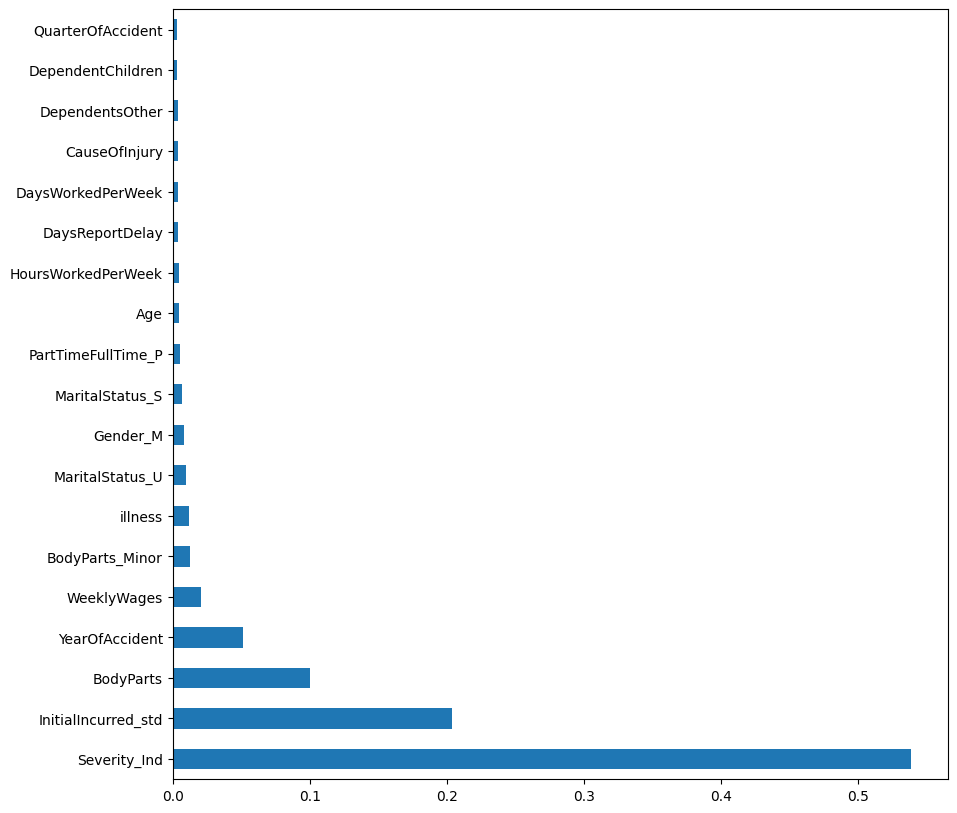

In [ ]:
# XGBoost: Plot feature importance
plt.rcParams["figure.figsize"] = 10, 10

(pd.Series(XGB.feature_importances_, index=X_train.columns).nlargest(20).plot(kind='barh'))
plt.show()

## 5.3. Experiment with RNN

#### Tuning learning rate for RNN

In [ ]:
# Creates a model given an activation and learning rate
def create_model(learning_rate):

    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr = learning_rate)

    model = Sequential()
    model.add(Input(shape=(19,1), name='Input-Layer'))
    model.add(Dropout(0.3))
    model.add(LSTM(100))
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer=opt ,metrics=['MeanSquaredError', 'MeanAbsoluteError'])
    return model

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model = KerasRegressor(build_fn = create_model)

early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.1, patience = 5, verbose = 0)
callbacks = [early_stop]

params = {'learning_rate' : [0.01,0.1, 0.2, 0.3,0.4,0.5]}

grid_search = GridSearchCV(estimator=model,
                          param_grid=params,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          verbose=2)

In [ ]:
from keras.optimizers import Adam

grid_search.fit(X_train, y_train)

print('Best score obtained: {0}'.format(grid_search.best_score_))
print('Parameters:')

for param, value in grid_search.best_params_.items():
    print('\t{}: {}'.format(param, value))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


The `lr` argument is deprecated, use `learning_rate` instead.
2022-10-29 01:25:59.962023: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-10-29 01:26:01.807922: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


304/304 [==============================] - 1s 1ms/step
[CV] END .................................learning_rate=0.01; total time=   9.5s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END .................................learning_rate=0.01; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END .................................learning_rate=0.01; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END .................................learning_rate=0.01; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END .................................learning_rate=0.01; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.1; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.1; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.1; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.1; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.1; total time=   5.6s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.2; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.2; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.2; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.2; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.2; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.3; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.3; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.3; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.3; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.3; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.4; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.4; total time=   5.8s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.4; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.4; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.4; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.5; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.5; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.5; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.5; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


304/304 [==============================] - 1s 1ms/step
[CV] END ..................................learning_rate=0.5; total time=   5.0s


The `lr` argument is deprecated, use `learning_rate` instead.


1519/1519 [==============================] - 5s 3ms/step - loss: 52.2599 - mean_squared_error: 52.2599 - mean_absolute_error: 7.0661
Best score obtained: -52.25289562466885
Parameters:
	learning_rate: 0.01


#### Evaluate the performance of the best model

In [ ]:
GS_pred = grid_search.predict(X_test)
print(GS_pred)

169/169 [==============================] - 0s 1ms/step
[1. 1. 1. ... 1. 1. 1.]


In [ ]:
print('---------- Evaluation on Test Data ----------')
print("RMSE: ", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(GS_pred))))
print("")

---------- Evaluation on Test Data ----------
RMSE:  31732.338273119232



# 6. Stacking models - XGBoost and Light GBM

Based on the above results, it seems that XGBoost and Light GBM outperform RNN. This proves that complexity does not always lead to better performance. In this section we proceed to stack XGBoost and Light GBM to further optimize the result

In [ ]:
# Stacking
from sklearn.ensemble import StackingRegressor
models = [('lgb',LGBMRegressor(**best_pars_lgb)),('xbg',XGBRegressor(**best_pars_xgb))]
stacking = StackingRegressor(estimators=models)

stacking.fit(X_train, y_train)

result = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(stacking.predict(X_test))*1.1))  ## factor in the LDF and TF for LGB model only with log trans

print("Stacked Model Average CV RMSE %0.3f" % result)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Stacked Model Average CV RMSE 25484.517
